In [1]:
import numpy as np
from glob import glob

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

2023-04-17 17:48:06.829023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
from keras_unet_collection import models, base, utils

In [4]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/tmp/drive/oxford_iiit/'

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)


In [6]:
name = 'unet3plus'
activation = 'ReLU'
filter_num_down = [32, 64, 128, 256, 512]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 3

# `unet_3plus_2d_base` accepts an input tensor 
# and produces output tensors from different upsampling levels
# ---------------------------------------- #
input_tensor = keras.layers.Input((128, 128, 3))
# base architecture
X_decoder = base.unet_3plus_2d_base(
    input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate, 
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
    batch_norm=True, pool=True, unpool=True, backbone=None, name=name)

2023-04-17 17:48:19.429566: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-17 17:48:19.580502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-17 17:48:19.580544: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-17 17:48:19.584124: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 17:48:19.584158: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-17 17:48:19.585055: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [7]:
X_decoder

[<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'unet3plus_down4_conv_1_activation')>,
 <KerasTensor: shape=(None, 16, 16, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_0_0_activation')>,
 <KerasTensor: shape=(None, 32, 32, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_1_0_activation')>,
 <KerasTensor: shape=(None, 64, 64, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_2_0_activation')>,
 <KerasTensor: shape=(None, 128, 128, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_3_0_activation')>]

In [8]:
# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices 
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])
    
    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear', 
                     name='{}_output_sup{}'.format(name, i-1))(X)
    
    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

In [9]:
OUT_stack

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup0_activation')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup1_activation')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup2_activation')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup3_activation')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_final_activation')>]

In [10]:


# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1) # <----- This value could be trained with "none-organ image"

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        # deep-supervision
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        # final output
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))



In [11]:
OUT_stack

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup0_CGM')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup1_CGM')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup2_CGM')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_sup3_CGM')>,
 <KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'unet3plus_output_final_CGM')>]

In [12]:
unet3plus = keras.models.Model([input_tensor,], OUT_stack)

In [13]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

In [14]:
unet3plus.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
                  loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [15]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

In [16]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 5912:739:739


In [17]:
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))

In [18]:
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))
test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))

In [19]:
N_epoch = 10 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        temp_out = unet3plus.predict([valid_input])
        y_pred = temp_out[-1]
        record = np.mean(hybrid_loss(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = unet3plus.train_on_batch([train_input,], 
                                         [train_target, train_target, train_target, train_target, train_target,])
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    temp_out = unet3plus.predict([valid_input])
    y_pred = temp_out[-1]
    record_temp = np.mean(hybrid_loss(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

2023-04-17 17:53:00.626341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-17 17:53:00.628098: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz
2023-04-17 17:53:01.035999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-17 17:53:01.793684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-17 17:53:02.571515: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-17 17:53:02.571544: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-17 17:53:02.571634: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modif

	Initial loss = 1.6084303855895996
Validation performance is improved from 1.6084303855895996 to 1.1379549503326416
Validation performance is improved from 1.1379549503326416 to 1.0530731678009033
Validation performance is improved from 1.0530731678009033 to 0.7357490062713623
Validation performance is improved from 0.7357490062713623 to 0.6896501779556274
Validation performance is improved from 0.6896501779556274 to 0.5604984760284424
Validation performance is improved from 0.5604984760284424 to 0.5585192441940308
Validation performance is improved from 0.5585192441940308 to 0.5406442880630493
Validation performance is improved from 0.5406442880630493 to 0.48804351687431335
Validation performance 0.516958475112915 is NOT improved
Validation performance is improved from 0.48804351687431335 to 0.48783349990844727


In [20]:
temp_out = unet3plus.predict([test_input,])
y_pred = temp_out[-1]

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax

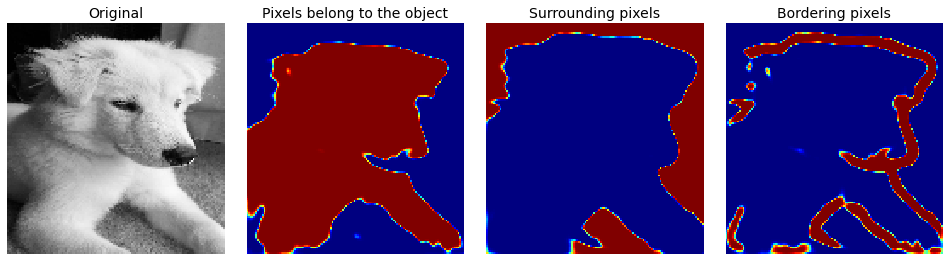

In [29]:
i_sample = 6

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
AX[3].pcolormesh(y_pred[i_sample, ..., 2], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);
AX[3].set_title("Bordering pixels", fontsize=14);


In [30]:
help(models.att_unet_2d)

Help on function att_unet_2d in module keras_unet_collection._model_att_unet_2d:

att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet')
    Attention U-net with an optional ImageNet backbone
    
    att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-

In [31]:
help(models.unet_plus_2d)

Help on function unet_plus_2d in module keras_unet_collection._model_unet_plus_2d:

unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    U-net++ with an optional ImageNet-trained backbone.
    
    unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for C